In [1]:
%pylab inline
%load_ext autotime
%load_ext autoreload
%autoreload 2
import scanpy as sc

from pysctransform.pysctransform import vst
from pysctransform.plotting import plot_fit, plot_residual_var, compare_with_sct


Populating the interactive namespace from numpy and matplotlib
time: 10.3 s (started: 2021-02-28 02:26:32 -05:00)


In [2]:
pbmc33k = sc.read_h5ad("../data/pbmc33k.h5ad")
pbmc3k = sc.read_h5ad("../data/pbmc3k.h5ad")

time: 1.28 s (started: 2021-02-28 02:26:43 -05:00)


# PBMC3k

Running Step1


100%|██████████| 2000/2000 [00:53<00:00, 37.69it/s]


Step1 done. Took 54.0 seconds.
Running Step2
Step2 done. Took 6.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.


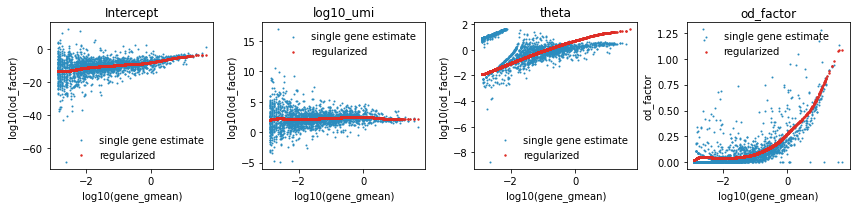

time: 1min 3s (started: 2021-02-28 02:26:44 -05:00)


In [3]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="theta_ml",
)
_ = plot_fit(vst_out_3k)


<AxesSubplot:xlabel='Residual variance'>

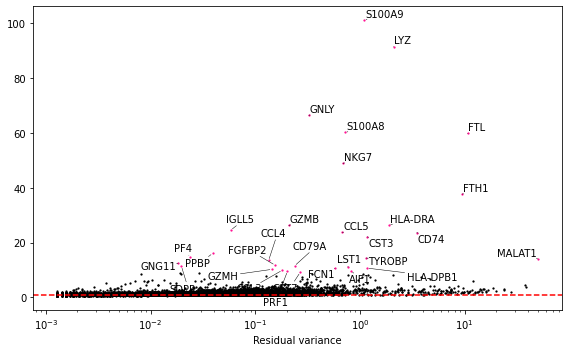

time: 6.91 s (started: 2021-02-28 02:27:48 -05:00)


In [4]:
plot_residual_var(vst_out_3k)

## Compare model parameters to R SCTransform

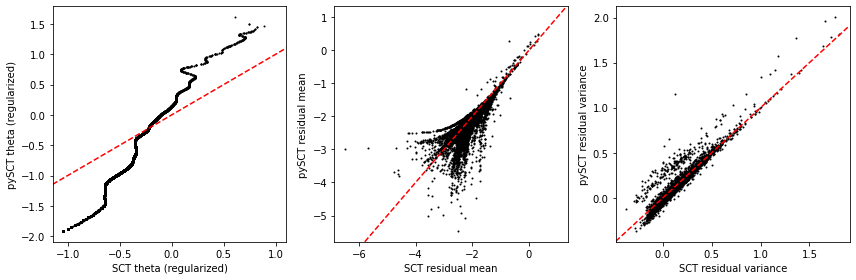

time: 670 ms (started: 2021-02-28 02:27:55 -05:00)


In [5]:
compare_with_sct(vst_out_3k, 
                 sct_modelparsfit_file="~/data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc3k/pbmc3k_thetaml_gene_attr.csv"
                )

# PBMC33k

Running Step1


100%|██████████| 2000/2000 [01:13<00:00, 27.10it/s]


Step1 done. Took 76.0 seconds.
Running Step2
Step2 done. Took 7.0 seconds.
Running Step3
Step3 done. Took 20.0 seconds.


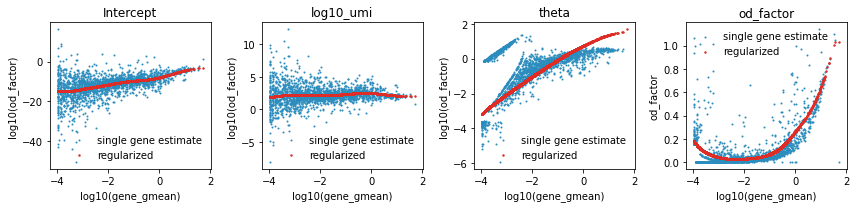

time: 1min 58s (started: 2021-02-28 02:27:55 -05:00)


In [6]:
# Input is gene x cell
vst_out_33k = vst(
    pbmc33k.X.T,
    gene_names=pbmc33k.var_names.tolist(),
    cell_names=pbmc33k.obs_names.tolist(),
    fit_type="theta_ml",
)
_ = plot_fit(vst_out_33k)


<AxesSubplot:xlabel='Residual variance'>

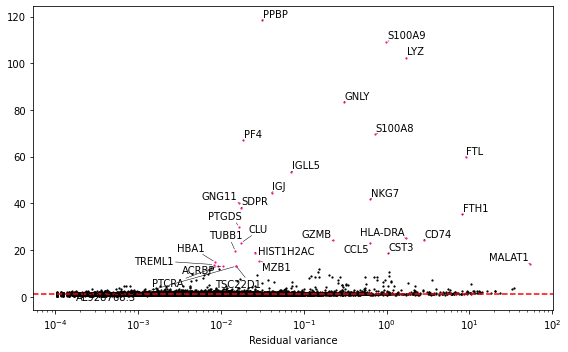

time: 4.29 s (started: 2021-02-28 02:29:54 -05:00)


In [7]:
plot_residual_var(vst_out_33k)

## Compare model parameters to R SCTransform

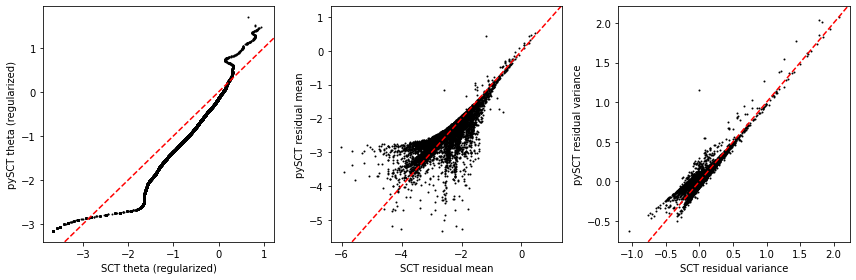

time: 713 ms (started: 2021-02-28 02:29:58 -05:00)


In [8]:
compare_with_sct(vst_out_33k, 
                 sct_modelparsfit_file="~/data/pbmc33k/pbmc33k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc33k/pbmc33k_thetaml_gene_attr.csv"
                )

# Try another estimator - theta_ml with LBFGS

Running Step1


100%|██████████| 2000/2000 [00:55<00:00, 35.87it/s]


Step1 done. Took 57.0 seconds.
Running Step2
Step2 done. Took 5.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.


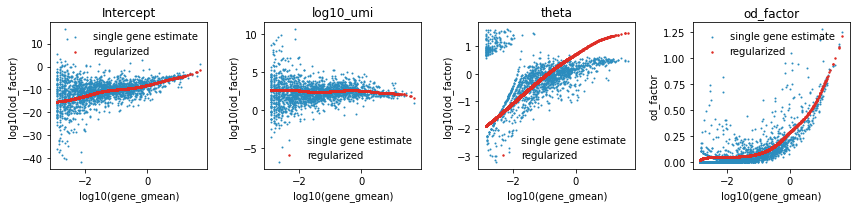

time: 1min 6s (started: 2021-02-28 02:29:59 -05:00)


In [9]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="theta_lbfgs",
)
_ = plot_fit(vst_out_3k)


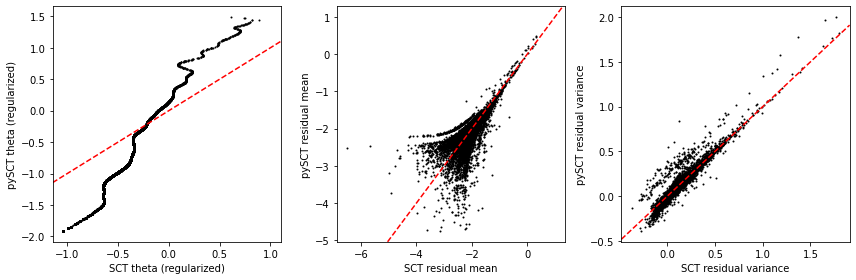

time: 1.75 s (started: 2021-02-28 02:31:05 -05:00)


In [10]:
compare_with_sct(vst_out_3k, 
                 sct_modelparsfit_file="~/data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc3k/pbmc3k_thetaml_gene_attr.csv"
                )

<AxesSubplot:xlabel='Residual variance'>

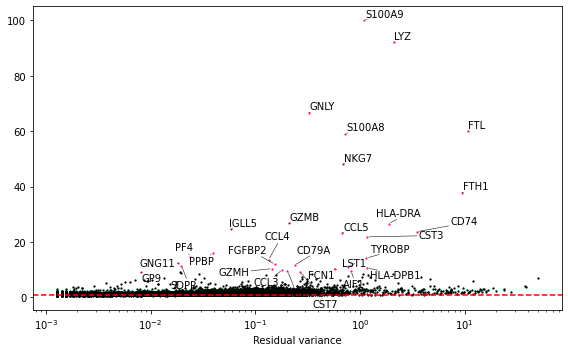

time: 21.8 s (started: 2021-02-28 02:31:07 -05:00)


In [11]:
plot_residual_var(vst_out_3k)

In [12]:
# Try another estimator - theta_ml with LBFGS applied to 1/theta parameter

time: 35.3 ms (started: 2021-02-28 02:31:29 -05:00)


In [13]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="alpha_lbfgs",
)


Running Step1


100%|██████████| 2000/2000 [00:49<00:00, 40.22it/s]


Step1 done. Took 51.0 seconds.
Running Step2
Step2 done. Took 5.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.
time: 58.2 s (started: 2021-02-28 02:31:29 -05:00)


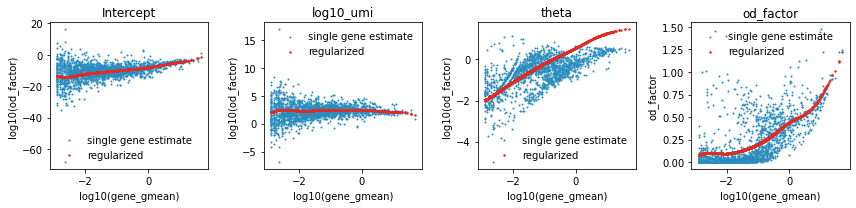

time: 11.7 s (started: 2021-02-28 02:32:27 -05:00)


In [14]:
_ = plot_fit(vst_out_3k)


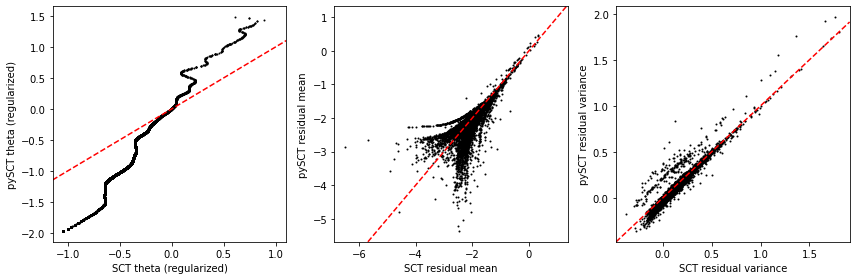

time: 364 ms (started: 2021-02-28 02:32:39 -05:00)


In [15]:
compare_with_sct(vst_out_3k, 
                 sct_modelparsfit_file="~/data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc3k/pbmc3k_thetaml_gene_attr.csv"
                )


<AxesSubplot:xlabel='Residual variance'>

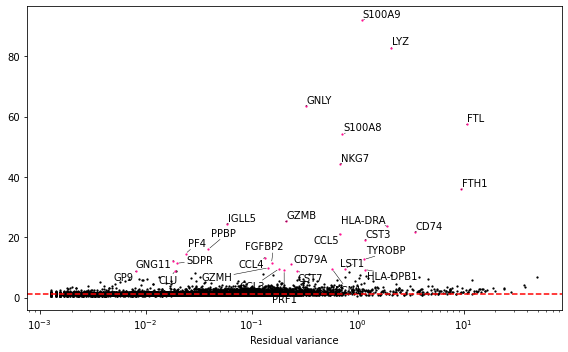

time: 14.3 s (started: 2021-02-28 02:32:39 -05:00)


In [16]:
plot_residual_var(vst_out_3k)